In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

import numpy as np

import bilby
from gwpy.timeseries import TimeSeries
logger = bilby.core.utils.logger

from bilby.core.prior import *
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries
from __future__ import division
import inspect
import os
from collections import OrderedDict, namedtuple
from copy import copy
from distutils.version import LooseVersion
from itertools import product
import corner
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import lines as mpllines
import numpy as np
import pandas as pd
import scipy.stats
from scipy.special import logsumexp

/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### GW170818

shape of the old posterior file we are reweighting
(22223, 50)
total number of elements =size of the weight file =
(22223,)
total number of non zero weights:
47
shape of the old posterior file we are reweighting
(17231, 50)
total number of elements =size of the weight file =
(17231,)
total number of non zero weights:
25


09:56 bilby INFO    : Rejection sampling resulted in 400 samples
09:56 bilby INFO    : Rejection sampling resulted in 158 samples


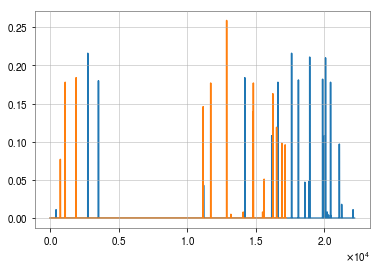

In [2]:
gw170818Acc = bilby.result.read_in_result(filename='../GW170818/nonAcc/outdir/fake2_prior_GW170818_result.json')
Copy_gw170818Acc = bilby.result.read_in_result(filename='../GW170818/nonAcc/outdir/fake2_prior_GW170818_result.json')
LIGO_gw170818 = bilby.result.read_in_result(filename='../GW170818/null/outdir/std_prior_GW170818_result.json')
Copy_LIGO_gw170818 = bilby.result.read_in_result(filename='../GW170818/null/outdir/std_prior_GW170818_result.json')
gw170818 = bilby.result.read_in_result(filename='../GW170818/nonAcc/outdir/nonAcc_prior_GW170818_result.json')


weightFile_fake=np.loadtxt('../Gw170818_reweight/Fake2_new_weight_gw170818.csv')

print("shape of the old posterior file we are reweighting")
print(np.shape(gw170818Acc.posterior))

plt.plot(weightFile_fake)

nonzero_weight_index1=[]
for i in range(len(weightFile_fake)):
    if weightFile_fake[i]!=0:
        nonzero_weight_index1=np.append(nonzero_weight_index1,i)

print("total number of elements =size of the weight file =")
print(np.shape(weightFile_fake))
print("total number of non zero weights:")
print(len(nonzero_weight_index1))


weightFile_Ligo=np.loadtxt('gw170818/LIGO_prior/gw170818_LIGOprior_toz10cuttoff.csv')

print("shape of the old posterior file we are reweighting")
print(np.shape(LIGO_gw170818.posterior))

plt.plot(weightFile_Ligo)

nonzero_weight_index=[]
for i in range(len(weightFile_Ligo)):
    if weightFile_Ligo[i]!=0:
        nonzero_weight_index=np.append(nonzero_weight_index,i)

print("total number of elements =size of the weight file =")
print(np.shape(weightFile_Ligo))
print("total number of non zero weights:")
print(len(nonzero_weight_index))


#for LIGO prior resampling
nposterior = len(LIGO_gw170818.posterior)
old_log_likelihood_array = np.zeros(nposterior)
old_log_prior_array = np.zeros(nposterior)
new_log_likelihood_array = np.zeros(nposterior)
new_log_prior_array = np.zeros(nposterior)


for ii, sample in LIGO_gw170818.posterior.iterrows():
    # Convert sample to dictionary
    par_sample = {key: sample[key] for key in LIGO_gw170818.search_parameter_keys[:-1]}
    #NOTE: jitter time is goving some problems - so I remove that key from the samples in this step; Should not effect anything but check
    old_log_likelihood_array[ii] = sample["log_likelihood"]
    new_log_likelihood_array[ii] = old_log_likelihood_array[ii]
    old_log_prior_array[ii] = sample["log_prior"]
    
    if weightFile_Ligo[ii] != 0.0:
        new_log_prior_array[ii] = np.log(weightFile_Ligo[ii])
    else:
        new_log_prior_array[ii] = 0.0
        #Note: if the new prior is narrow, a lot of points with have log of 0 and fail. Around 12 samples were present in the whole LIGO prior run that did not give inf for log pBH prior.
        
ln_weights_LIGO = (
        new_log_likelihood_array + new_log_prior_array - old_log_likelihood_array - old_log_prior_array)


weightsLIGO = np.exp(ln_weights_LIGO)
keep = weightsLIGO > np.random.uniform(0, max(weightsLIGO), weightsLIGO.shape)
LIGO_gw170818.posterior = LIGO_gw170818.posterior[keep]

logger.info("Rejection sampling resulted in {} samples".format(len(LIGO_gw170818.posterior)))

#for fake prior resampling
nposterior = len(gw170818Acc.posterior)
old_log_likelihood_array = np.zeros(nposterior)
old_log_prior_array = np.zeros(nposterior)
new_log_likelihood_array = np.zeros(nposterior)
new_log_prior_array = np.zeros(nposterior)


for ii, sample in gw170818Acc.posterior.iterrows():
    # Convert sample to dictionary
    par_sample = {key: sample[key] for key in gw170818Acc.search_parameter_keys[:-1]}
    #NOTE: jitter time is goving some problems - so I remove that key from the samples in this step; Should not effect anything but check
    old_log_likelihood_array[ii] = sample["log_likelihood"]
    new_log_likelihood_array[ii] = old_log_likelihood_array[ii]
    old_log_prior_array[ii] = sample["log_prior"]
    
    if weightFile_fake[ii] != 0.0:
        new_log_prior_array[ii] = np.log(weightFile_fake[ii])
    else:
        new_log_prior_array[ii] = 0.0
        #Note: if the new prior is narrow, a lot of points with have log of 0 and fail. Around 12 samples were present in the whole LIGO prior run that did not give inf for log pBH prior.
        
ln_weights_Fake = (
        new_log_likelihood_array + new_log_prior_array - old_log_likelihood_array - old_log_prior_array)


weightsFake = np.exp(ln_weights_Fake)
keep = weightsFake > np.random.uniform(0, max(weightsFake), weightsFake.shape)
gw170818Acc.posterior = gw170818Acc.posterior[keep]

logger.info("Rejection sampling resulted in {} samples".format(len(gw170818Acc.posterior)))
   
   

In [3]:
figLIGO=gw170818.plot_corner(filename="Plot_Store/gw170818_all3LIGOCase.png",  quantiles=[0.05,0.95],verbose=True, labels=["Mc", "q","$\chi_{eff}$"],show_titles=False,parameters=["chirp_mass", "mass_ratio", "chi_eff"],  scale_hist=False, color='slateblue')
Copy_LIGO_gw170818.plot_corner(filename="Plot_Store/gw170818_all3LIGOCase.png",fig=figLIGO,quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='yellowgreen')
LIGO_gw170818.plot_corner(filename="Plot_Store/gw170818_all3LIGOCase.png",fig=figLIGO,quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='coral')

Quantiles:
[(0.05, 31.846293561045094), (0.95, 33.47581257812204)]
Quantiles:
[(0.05, 0.5085552235259647), (0.95, 0.975891981633362)]
Quantiles:
[(0.05, -0.003715102189656006), (0.95, 0.0035755037920715696)]


/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Quantiles:
[(0.05, 29.80760343143398), (0.95, 35.09983628590987)]
Quantiles:
[(0.05, 0.4557362570796344), (0.95, 0.9670692823546283)]
Quantiles:
[(0.05, -0.2736841867012587), (0.95, 0.14068270925084017)]
Quantiles:
[(0.05, 29.377405290008255), (0.95, 35.03887378930852)]
Quantiles:
[(0.05, 0.4483747992160387), (0.95, 0.964316925807036)]
Quantiles:
[(0.05, -0.3054558169841422), (0.95, 0.13723321081669557)]


UnicodeEncodeError: 'ascii' codec can't encode character '\u2212' in position 249: ordinal not in range(128)

<Figure size 547.2x547.2 with 9 Axes>

In [4]:
!ls ../GW190412/nonAcc/outdir/nonacc_prior_GW190412_result.json

../GW190412/nonAcc/outdir/nonacc_prior_GW190412_result.json


In [5]:
!ls gw190412/LIGO_prior/weights_gw190412_LIGOprior_toz10cuttoff.csv

gw190412/LIGO_prior/weights_gw190412_LIGOprior_toz10cuttoff.csv


In [10]:
LIGO_GW190412 = bilby.result.read_in_result(filename='../GW190412/null/outdir/std_prior_GW190412_result.json')
copy_LIGO_GW190412 = bilby.result.read_in_result(filename='../GW190412/null/outdir/std_prior_GW190412_result.json')

In [11]:
Acc_GW190412 = bilby.result.read_in_result(filename='../GW190412/nonAcc/outdir/nonacc_prior_GW190412_result.json')


shape of the old posterior file we are reweighting
(176, 50)
total number of elements =size of the weight file =
(23268,)
total number of non zero weights:
2


IndexError: index 182 is out of bounds for axis 0 with size 176

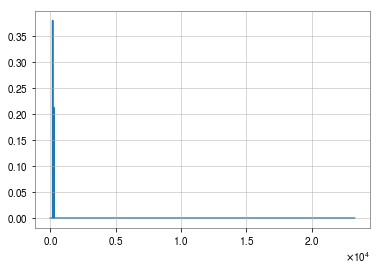

In [14]:
weightFile_Ligo=np.loadtxt('gw190412/LIGO_prior/weights_gw190412_LIGOprior_toz10cuttoff.csv')

print("shape of the old posterior file we are reweighting")
print(np.shape(LIGO_GW190412.posterior))

plt.plot(weightFile_Ligo)

nonzero_weight_index=[]
for i in range(len(weightFile_Ligo)):
    if weightFile_Ligo[i]!=0:
        nonzero_weight_index=np.append(nonzero_weight_index,i)

print("total number of elements =size of the weight file =")
print(np.shape(weightFile_Ligo))
print("total number of non zero weights:")
print(len(nonzero_weight_index))


#for LIGO prior resampling
nposterior = len(LIGO_GW190412.posterior)
old_log_likelihood_array = np.zeros(nposterior)
old_log_prior_array = np.zeros(nposterior)
new_log_likelihood_array = np.zeros(nposterior)
new_log_prior_array = np.zeros(nposterior)


for ii, sample in LIGO_GW190412.posterior.iterrows():
    # Convert sample to dictionary
    par_sample = {key: sample[key] for key in LIGO_GW190412.search_parameter_keys[:-1]}
    #NOTE: jitter time is goving some problems - so I remove that key from the samples in this step; Should not effect anything but check
    old_log_likelihood_array[ii] = sample["log_likelihood"]
    new_log_likelihood_array[ii] = old_log_likelihood_array[ii]
    old_log_prior_array[ii] = sample["log_prior"]
    
    if weightFile_Ligo[ii] != 0.0:
        new_log_prior_array[ii] = np.log(weightFile_Ligo[ii])
    else:
        new_log_prior_array[ii] = 0.0
        #Note: if the new prior is narrow, a lot of points with have log of 0 and fail. Around 12 samples were present in the whole LIGO prior run that did not give inf for log pBH prior.
        
ln_weights_LIGO = (
        new_log_likelihood_array + new_log_prior_array - old_log_likelihood_array - old_log_prior_array)


weightsLIGO = np.exp(ln_weights_LIGO)
keep = weightsLIGO > np.random.uniform(0, max(weightsLIGO), weightsLIGO.shape)
LIGO_GW190412.posterior = LIGO_GW190412.posterior[keep]

logger.info("Rejection sampling resulted in {} samples".format(len(LIGO_GW190412.posterior)))


Quantiles:
[(0.05, 14.847321486962374), (0.95, 15.28177959931497)]
Quantiles:
[(0.05, 0.4704284348933797), (0.95, 0.9364318732739824)]
Quantiles:
[(0.05, -0.0035887333135099344), (0.95, 0.003890187971654758)]


/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Quantiles:
[(0.05, 14.903986348448775), (0.95, 15.455487611660462)]
Quantiles:
[(0.05, 0.20464702441127844), (0.95, 0.3839196753813302)]
Quantiles:
[(0.05, 0.11982360076556142), (0.95, 0.32274437123627636)]


/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Quantiles:
[(0.05, 14.942192435306708), (0.95, 15.487932983532499)]
Quantiles:
[(0.05, 0.21817775712185927), (0.95, 0.41751690822177046)]
Quantiles:
[(0.05, 0.11260505528244522), (0.95, 0.3101706590791398)]


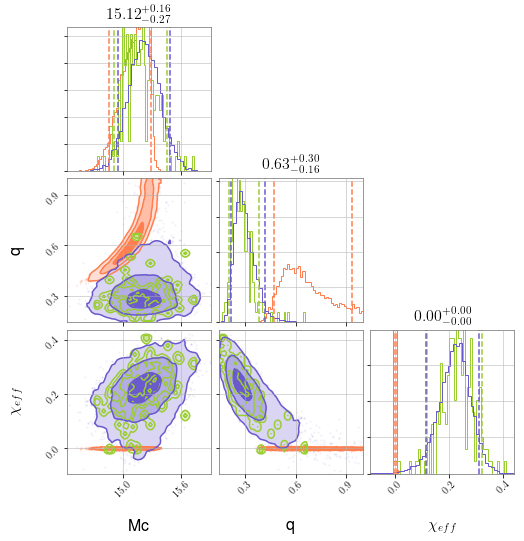

In [13]:
fig_gw190412=Acc_GW190412.plot_corner(filename="Plot_Store/GW190412_all3LIGOCase.png",quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='coral')
LIGO_GW190412.plot_corner(filename="Plot_Store/GW190412_all3LIGOCase.png", fig=fig_gw190412, quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='yellowgreen')
copy_LIGO_GW190412.plot_corner(filename="Plot_Store/GW190412_all3LIGOCase.png", fig=fig_gw190412, quantiles=[0.05,0.95],verbose=True, labels=["Mc", "q","$\chi_{eff}$"],show_titles=False,parameters=["chirp_mass", "mass_ratio", "chi_eff"],  scale_hist=False, color='slateblue')
